## Visualize

In [1]:
import matplotlib.pyplot as plt
import os
import json
import cv2
from collections import defaultdict
import numpy as np
from hico_text import hico_text_label
import torch

def get_max_logit_index(logit_index):
    # 같은 class내에서 예측된 bounding box 중 confidence가 높은 index 값 return
    index = torch.argmax(logit_index, dim=0)
    return index

def draw_bounding_box(image, point, color=(0, 255, 0), thickness=2):
    # OpenCV를 사용하여 bounding box 그리기
    x1, y1, x2, y2 = map(int, point)  # 좌표를 정수로 변환
    x1, y1, x2, y2 = max(0, x1), max(0, y1), max(0, x2), max(0, y2)  # 음수 값을 방지
    cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    return image
def get_centered_point(point):
    # 한 포인트의 중간 좌표 return
    x1, y1, x2, y2 = map(int, point)  # 좌표를 정수로 변환
    x1, y1, x2, y2 = max(0, x1), max(0, y1), max(0, x2), max(0, y2)  # 음수 값을 방지
    x = int((x2 + x1) / 2)
    y = int((y2 + y1) / 2)
    return x, y

def get_centered_bbox(image, point0, point1):
    # 두 bounding box의 중심점 간 선 이어주기
    x1, y1 = get_centered_point(point0)
    x2, y2 = get_centered_point(point1)
    print((x1, y1), (x2, y2))
    cv2.line(image, (x1, y1), (x2, y2), 255, 2)
    return image



/home/user/anaconda3/envs/de/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
len(hico_text_label.keys())

600

In [13]:
hico2coco = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,
                        14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                        24, 25, 27, 28, 31, 32, 33, 34, 35, 36,
                        37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
                        48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
                        58, 59, 60, 61, 62, 63, 64, 65, 67, 70,
                        72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                        82, 84, 85, 86, 87, 88, 89, 90)
coco2hico = {v:i for i, v in enumerate(hico2coco)}

In [34]:
with open("/home/user/jjunsss/DiffCL-DETR/hicodet/instances_test2015.json", 'r') as f:
    train_annotations = json.load(f)
    
print(train_annotations["rare"])

[8, 22, 27, 44, 50, 55, 62, 63, 66, 70, 76, 77, 80, 83, 84, 90, 99, 100, 104, 107, 112, 127, 135, 136, 149, 158, 165, 166, 168, 172, 179, 181, 184, 188, 189, 192, 195, 198, 205, 206, 214, 216, 222, 227, 229, 238, 239, 254, 255, 257, 260, 261, 262, 274, 279, 280, 281, 286, 289, 292, 303, 311, 315, 317, 325, 328, 333, 334, 345, 350, 351, 354, 358, 364, 379, 381, 389, 390, 391, 395, 397, 398, 399, 401, 402, 403, 404, 405, 407, 410, 416, 418, 426, 427, 429, 431, 436, 439, 440, 449, 451, 463, 469, 474, 482, 485, 498, 499, 504, 509, 514, 517, 520, 522, 526, 531, 535, 539, 546, 547, 548, 549, 550, 551, 552, 555, 556, 560, 578, 580, 581, 586, 592, 593, 595, 596, 597, 599]


In [14]:
hoi_anno_path = 'hico_list_hoi.txt'
verb_anno_path = 'hico_list_vb.txt'
obj_anno_path = 'hico_list_obj.txt'

with open(hoi_anno_path, 'r') as f:
    hoi_anno = f.readlines()
with open(verb_anno_path, 'r') as f:
    verb_anno = f.readlines()
# with open(obj_anno_path, 'r') as f:
#     obj_anno = f.readlines()

hoi_anno = [h.strip().split() for h in hoi_anno[2:]]
verb_anno = [v.strip().split() for v in verb_anno[2:]]
# obj_anno = [o.strip().split() for o in obj_anno[2:]]

verb_idx2class = {int(v[0]) : v[1] for v in verb_anno}
obj_idx2class = {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 
                 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 
                 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 
                 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 
                 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 
                 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 
                 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 
                 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven', 
                 80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 
                 90: 'toothbrush'}
for k,v in obj_idx2class.items():
    if len(v.split()) > 1:
        obj_idx2class[k] = '_'.join(v.split())

verb_class2idx = {v:k for k,v in verb_idx2class.items()}
obj_class2idx = {v:k for k,v in obj_idx2class.items()}

obj_in_verb = defaultdict(list)

for h in hoi_anno:
    idx, obj, verb = h
    verb_idx = verb_class2idx[verb]
    obj_idx = obj_class2idx[obj]
    obj_in_verb[verb_idx].append(obj_idx)

In [9]:
obj_in_verb

defaultdict(list,
            {5: [5, 9, 6, 3, 7],
             18: [5, 6, 3, 8],
             26: [5, 9, 6, 7],
             31: [5, 38],
             42: [5,
              2,
              9,
              44,
              6,
              3,
              18,
              4,
              53,
              27,
              52,
              15,
              47,
              11,
              31,
              38,
              55,
              79,
              35,
              37,
              42,
              43,
              32,
              8],
             53: [5, 6, 3, 19, 7, 33, 42, 8],
             77: [5, 2, 9, 6, 3, 21, 19, 4, 20, 7, 22, 25, 41, 35, 36, 42, 8],
             88: [5, 2, 9, 6, 62, 63, 4, 7, 65, 15, 41, 42, 70, 8],
             112: [5,
              2,
              9,
              6,
              3,
              17,
              18,
              19,
              4,
              20,
              7,
              53,
              51,
      

In [19]:
anno_file = '/home/user/jjunsss/DiffCL-DETR/hoidataset/trainval_hico.json'
# anno_file = "extra_data/google_crawling/crawl_annotations_updated.pt" # extra data annatation set.
# anno_file = '/mnt/HDD/hico_20160224_det/annotations/new_annotations_carrying_surfboard.json'
# anno_file = '/mnt/HDD/hico_20160224_det/annotations/new_annotations.json'
# anno_file = '/mnt/HDD/hico_20160224_det/annotations/trainval_hico_diffusion_replace.json'
# anno_file = '/mnt/HDD/hico_20160224_det/annotations/test_hico.json'

with open(anno_file, 'r') as f:
    annotations = json.load(f)

# annotations = torch.load("extra_data/google_crawling/crawl_annotations_updated.pt")
# annotations = annotations[37633:]
len(annotations)

37633

In [20]:
from pprint import pprint
pprint(annotations[0])

{'annotations': [{'bbox': [207, 32, 426, 299], 'category_id': 1},
                 {'bbox': [58, 97, 571, 404], 'category_id': 4}],
 'file_name': 'HICO_train2015_00000001.jpg',
 'hoi_annotation': [{'category_id': 73,
                     'hoi_category_id': 153,
                     'object_id': 1,
                     'subject_id': 0},
                    {'category_id': 77,
                     'hoi_category_id': 154,
                     'object_id': 1,
                     'subject_id': 0},
                    {'category_id': 88,
                     'hoi_category_id': 155,
                     'object_id': 1,
                     'subject_id': 0},
                    {'category_id': 99,
                     'hoi_category_id': 156,
                     'object_id': 1,
                     'subject_id': 0}],
 'img_id': 1}


In [24]:
hoi_test = annotations[0]["hoi_annotation"]
# print(hoi_test)
print(annotations[0]["annotations"][hoi_test[0]["subject_id"]])
print(annotations[0]["annotations"][hoi_test[0]["object_id"]])

{'bbox': [207, 32, 426, 299], 'category_id': 1}
{'bbox': [58, 97, 571, 404], 'category_id': 4}


In [22]:
# 'category_id'가 58인 'item_detail'을 포함하는 첫 번째 'item'의 인덱스를 찾습니다.
index = next(
    (i for i, item in enumerate(annotations) if any(
        item_detail["category_id"] == 80 for item_detail in item["hoi_annotation"]
    )),
    None  # 'category_id'가 58인 요소를 찾지 못한 경우 None을 반환합니다.
)
37633
# 결과 출력
if index is not None:
    print(f"Found at index: {index}")
else:
    print("No matching item found.")

Found at index: 77


{'annotations': [{'bbox': array([ 334.04633,  428.63977, 1382.0261 , 1584.5784 ], dtype=float32),
                  'category_id': 1},
                 {'bbox': array([ 132.44794, 1664.3398 ,  782.5647 , 2600.1895 ], dtype=float32),
                  'category_id': 86}],
 'file_name': '/nas2/lait/1000_Members/softjin/google_crawling/making vase/a '
              'photo of a person making vase/google_0059.jpg',
 'hoi_annotation': [{'category_id': 55,
                     'hoi_category_id': 586,
                     'object_id': 1,
                     'subject_id': 0}],
 'img_id': 9987}
extra_data/google_crawling/making vase/a photo of a person making vase/google_0059.jpg
/nas2/lait/1000_Members/softjin/google_crawling/making vase/a photo of a person making vase/google_0059.jpg
585:make_vase


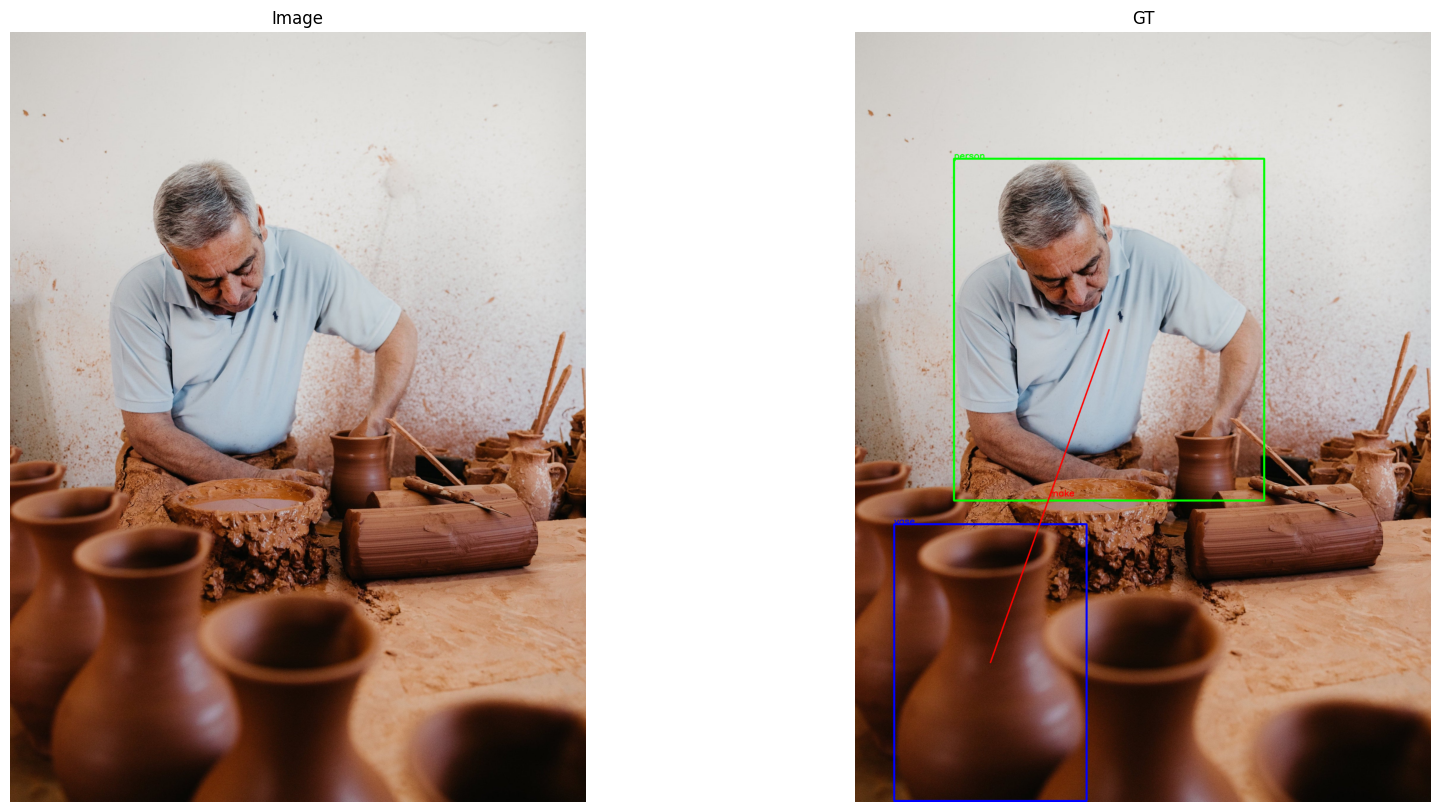

True

In [55]:
from pathlib import Path

#16208, 19082, 20944
# root_path = 'hico_20160224_det/images/train2015'
# root_path = '/mnt/HDD/hico_20160224_det/images/test2015'


idx = 9987
pprint(annotations[idx])
img_path = annotations[idx]['file_name']

# Image path change to custom path.
path_obj = Path(img_path)

# 경로의 특정 부분을 추출합니다.
parts = path_obj.parts  # 경로의 각 부분을 튜플로 분할
relevant_parts = parts[parts.index('google_crawling')+1:]

my_rootpath = "extra_data/google_crawling/"
root_path = os.path.join(my_rootpath, *relevant_parts)
print(root_path)

# bbox 좌표를 정수형 튜플로 변환하는 함수
def to_int_tuple(bbox):
    return tuple(map(int, bbox))


# img = cv2.imread(os.path.join(root_path,img_path))
img = cv2.imread(root_path)
ori_img = img.copy()
print(img_path)

hico_key2idx = {k:i for i, k in enumerate(list(hico_text_label.keys()))}
results = []
for k, anno in enumerate(annotations[idx]['hoi_annotation']):
    sub_id = anno['subject_id']
    obj_id = anno['object_id']
    sub_info = annotations[idx]['annotations'][sub_id]
    obj_info = annotations[idx]['annotations'][obj_id]
    
    sub_category_id = sub_info['category_id']
    obj_category_id = obj_info['category_id']
    
    sub_category = obj_idx2class[sub_category_id]
    obj_category = obj_idx2class[obj_category_id]
    
    # sub_bbox = sub_info['bbox']
    # obj_bbox = obj_info['bbox']
    
    sub_bbox = to_int_tuple(sub_info['bbox'])
    obj_bbox = to_int_tuple(obj_info['bbox'])
    
    sub_center = ((sub_bbox[0] + sub_bbox[2])//2, (sub_bbox[1] + sub_bbox[3])//2)
    obj_center = ((obj_bbox[0] + obj_bbox[2])//2, (obj_bbox[1] + obj_bbox[3])//2)
    
    verb_category_id = anno['category_id']
    verb_category = verb_idx2class[verb_category_id]

    if root_path.split('/')[-1] == 'train2015':
        hoi_category_id = anno['hoi_category_id']
    else:
        hoi_category_id = hico_key2idx[(verb_category_id-1, coco2hico[obj_category_id])]
    hoi_name = verb_idx2class[verb_category_id] + '_' + obj_idx2class[obj_category_id]
    print(f'{hoi_category_id}:{hoi_name}')
        
    
    
    cv2.rectangle(img, sub_bbox[:2], sub_bbox[2:], (0,255,0), 5)
    cv2.rectangle(img, obj_bbox[:2], obj_bbox[2:], (255,0,0), 5)
    cv2.line(img, sub_center, obj_center, (0,0,255), thickness=3)
    
    verb_loc = [(sub_center[0] + obj_center[0])//2, (sub_center[1] + obj_center[1])//2]
    verb_loc[1] += k*20
    cv2.putText(img, sub_category, sub_bbox[:2], cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    cv2.putText(img, obj_category, obj_bbox[:2], cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(img, verb_category, verb_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    
    result_dict = {}
    result_dict['verb'] = verb_category
    result_dict['object'] = obj_category
    result_dict['sub_bbox'] = sub_bbox
    result_dict['obj_bbox'] = obj_bbox
    
    results.append(result_dict)
    
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(ori_img[...,::-1])
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(img[...,::-1])
axes[1].set_title('GT')
axes[1].axis('off')

plt.show()
cv2.imwrite('cooking a carrot3.png', img)

In [9]:
verb_idx=verb_class2idx[results[0]['verb']]
print(results[0]['verb'])
print([obj_idx2class[idx] for idx in obj_in_verb[verb_idx]])
print([hico_text_label[(verb_idx-1, coco2hico[idx])] for idx in obj_in_verb[verb_idx]])

sit_on
['airplane', 'bicycle', 'boat', 'bus', 'chair', 'couch', 'motorcycle', 'train', 'bed', 'bench', 'skateboard', 'surfboard', 'toilet', 'truck']
['a photo of a person sitting on an airplane', 'a photo of a person sitting on a bicycle', 'a photo of a person sitting on a boat', 'a photo of a person sitting on a bus', 'a photo of a person sitting on a chair', 'a photo of a person sitting on a couch', 'a photo of a person sitting on a motorcycle', 'a photo of a person sitting on a train', 'a photo of a person sitting on a bed', 'a photo of a person sitting on a bench', 'a photo of a person sitting on a skateboard', 'a photo of a person sitting on a surfboard', 'a photo of a person sitting on a toilet', 'a photo of a person sitting on a truck']


In [48]:
# check extra dataset

import torch
bbox_datas = 'extra_data/google_crawling/making vase/making vase_bbox_elaborate.pt'
datas = torch.load(bbox_datas)

In [7]:
from pathlib import Path

# Image path change to custom path.
absolute_path = datas[N]["file_name"]
path_obj = Path(absolute_path)

# 경로의 특정 부분을 추출합니다.
parts = path_obj.parts  # 경로의 각 부분을 튜플로 분할
relevant_parts = parts[parts.index('google_crawling')+1:]
print(parts)
print(relevant_parts)
print(path_obj.name)
my_rootpath = "extra_data/google_crawling/"
new_path = os.path.join(my_rootpath, *relevant_parts)
print(new_path)


('/', 'nas2', 'lait', '1000_Members', 'softjin', 'google_crawling', 'sailing boat', 'a photo of a person sailing boat', 'google_0014.jpg')
('sailing boat', 'a photo of a person sailing boat', 'google_0014.jpg')
google_0014.jpg
extra_data/google_crawling/sailing boat/a photo of a person sailing boat/google_0014.jpg


extra_data/google_crawling/making vase/a photo of a person making vase/google_0059.jpg
 list : [{'bbox': array([ 334.04633,  428.63977, 1382.0261 , 1584.5784 ], dtype=float32), 'phrase': 'person', 'category_id': 1, 'logits': tensor(0.9158)}]
person
person
 list : [{'bbox': array([ 132.44794, 1664.3398 ,  782.5647 , 2600.1895 ], dtype=float32), 'phrase': 'vase', 'category_id': 86, 'logits': tensor(0.7114)}, {'bbox': array([1.3317261e+00, 1.5339797e+03, 4.0549158e+02, 2.4380391e+03],
      dtype=float32), 'phrase': 'vase', 'category_id': 86, 'logits': tensor(0.6600)}, {'bbox': array([ 611.2235, 1893.67  , 1304.713 , 2601.075 ], dtype=float32), 'phrase': 'vase', 'category_id': 86, 'logits': tensor(0.6675)}, {'bbox': array([1076.1792, 1337.4161, 1299.1621, 1640.1898], dtype=float32), 'phrase': 'vase', 'category_id': 86, 'logits': tensor(0.5567)}, {'bbox': array([7.0960999e-01, 1.4463875e+03, 1.9402275e+02, 1.9831685e+03],
      dtype=float32), 'phrase': 'vase', 'category_id': 86, 'logits':

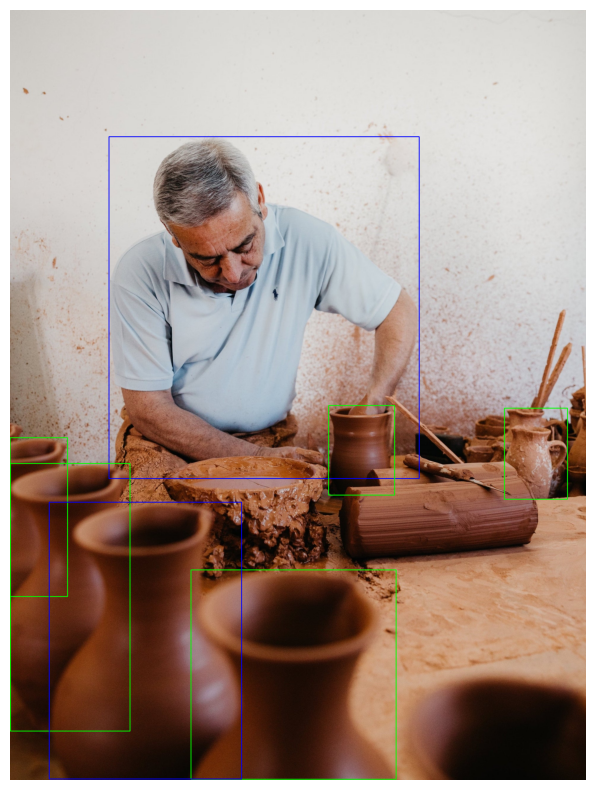

In [52]:
import cv2
from matplotlib import pyplot as plt
import torch  # torch 라이브러리가 필요합니다.
from pathlib import Path

# 이미지 번호
N = 45 # Index

# Image path change to custom path.
absolute_path = datas[N]["file_name"]
path_obj = Path(absolute_path)

# 경로의 특정 부분을 추출합니다.
parts = path_obj.parts  # 경로의 각 부분을 튜플로 분할
relevant_parts = parts[parts.index('google_crawling')+1:]

my_rootpath = "extra_data/google_crawling/"
new_path = os.path.join(my_rootpath, *relevant_parts)
print(new_path)


# 이미지 불러오기
image_path = new_path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # cv2는 BGR로 이미지를 불러오므로, RGB로 변환합니다.

# 이미지에 바운딩 박스 그리기
for object_name, object_list in datas[N]['annotations'].items():
    print(f" list : {object_list}")
    for i_object in object_list:
        point = i_object['bbox']

        # bounding box 그리기
        image = draw_bounding_box(image, point)

    # confidence 값이 높은 오브젝트의 bounding box 그리기
    lists = []
    for v in object_list:
        lists.append(v['logits'])
    max_index = get_max_logit_index(torch.stack(lists, 0))
    point = object_list[max_index]['bbox']
    image = draw_bounding_box(image, point, color=(0, 0, 255))
    print(object_name)
    print(object_list[max_index]['phrase'])

# bounding box가 그려진 이미지 저장
# output_path = f"image_with_bbox_{N}.jpg"
# cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  # 다시 BGR 형식으로 변환하여 저장합니다.

# 이미지 표시
plt.figure(figsize=(10, 10))  # 이미지 크기 조정
plt.imshow(image)
plt.axis('off')  # 축 제거
plt.show()


## Dataset statistic

In [1]:
import matplotlib.pyplot as plt
import os
import json
import cv2
from collections import defaultdict
import numpy as np
from hico_text import hico_text_label

In [2]:
hico2coco = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,
                        14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                        24, 25, 27, 28, 31, 32, 33, 34, 35, 36,
                        37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
                        48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
                        58, 59, 60, 61, 62, 63, 64, 65, 67, 70,
                        72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                        82, 84, 85, 86, 87, 88, 89, 90)
coco2hico = {v:i for i, v in enumerate(hico2coco)}

In [3]:
hoi_anno_path = '/mnt/HDD/hico_20160224_det/hico_list_hoi.txt'
verb_anno_path = '/mnt/HDD/hico_20160224_det/hico_list_vb.txt'

with open(hoi_anno_path, 'r') as f:
    hoi_anno = f.readlines()
with open(verb_anno_path, 'r') as f:
    verb_anno = f.readlines()

hoi_anno = [h.strip().split() for h in hoi_anno[2:]]
verb_anno = [v.strip().split() for v in verb_anno[2:]]

verb_idx2class = {int(v[0]) : v[1] for v in verb_anno}
obj_idx2class = {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 
                 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 
                 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 
                 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 
                 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 
                 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 
                 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 
                 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven', 
                 80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 
                 90: 'toothbrush'}
for k,v in obj_idx2class.items():
    if len(v.split()) > 1:
        obj_idx2class[k] = '_'.join(v.split())

verb_class2idx = {v:k for k,v in verb_idx2class.items()}
obj_class2idx = {v:k for k,v in obj_idx2class.items()}

obj_in_verb = defaultdict(list)

for h in hoi_anno:
    idx, obj, verb = h
    verb_idx = verb_class2idx[verb]
    obj_idx = obj_class2idx[obj]
    obj_in_verb[verb_idx].append(obj_idx)

In [4]:
list(obj_idx2class.values())

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic_light',
 'fire_hydrant',
 'stop_sign',
 'parking_meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports_ball',
 'kite',
 'baseball_bat',
 'baseball_glove',
 'skateboard',
 'surfboard',
 'tennis_racket',
 'bottle',
 'wine_glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot_dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted_plant',
 'bed',
 'dining_table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell_phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy_bear',
 'hair_drier',
 'toothbrush']

In [5]:
train_anno_file = '/mnt/HDD/hico_20160224_det/annotations/trainval_hico.json'
# train_anno_file = '/mnt/HDD/hico_20160224_det/annotations/trainval_hico_diffusion_replace.json'
hico_key2idx = {k:i for i, k in enumerate(list(hico_text_label.keys()))}

with open(train_anno_file, 'r') as f:
    train_annotations = json.load(f)

# annotations = annotations[37633:]

train_num_of_obj = defaultdict(int)
train_num_of_verb = defaultdict(int)
train_num_of_hoi = defaultdict(int)

train_num_of_obj_img = defaultdict(set)
train_num_of_verb_img = defaultdict(set)
train_num_of_hoi_img = defaultdict(set)


train_hoi2verbobj = {}
for anno in train_annotations:
    for ins in anno['annotations']:
        obj_category_id = ins['category_id']
        train_num_of_obj[obj_category_id] += 1
        train_num_of_obj_img[obj_category_id].add(anno['file_name'])

    for ins in anno['hoi_annotation']:
        verb_category_id = ins['category_id'] # 1~117
        # hoi_category_id = ins['hoi_category_id'] # 1~600
        
        obj_id = ins['object_id']
        obj_cat_id = anno['annotations'][obj_id]['category_id']
        hoi_category_id = hico_key2idx[(verb_category_id-1, coco2hico[obj_cat_id])]
        
        train_num_of_verb[verb_category_id] += 1
        train_num_of_hoi[hoi_category_id] += 1
        
        train_num_of_verb_img[verb_category_id].add(anno['file_name'])
        train_num_of_hoi_img[hoi_category_id].add(anno['file_name'])
            
        sub_id = ins['subject_id']
        obj_id = ins['object_id']
        
        train_hoi2verbobj[hoi_category_id] = (verb_category_id, anno['annotations'][obj_id]['category_id'])
    
test_anno_file = '/mnt/HDD/hico_20160224_det/annotations/test_hico.json'

with open(test_anno_file, 'r') as f:
    test_annotations = json.load(f)

test_num_of_obj = defaultdict(int)
test_num_of_verb = defaultdict(int)
test_num_of_hoi = defaultdict(int)

test_num_of_obj_img = defaultdict(set)
test_num_of_verb_img = defaultdict(set)
test_num_of_hoi_img = defaultdict(set)
test_hoi2verbobj = {}

hico_key2idx = {k:i for i, k in enumerate(list(hico_text_label.keys()))}

for anno in test_annotations:
    for ins in anno['annotations']:
        obj_category_id = ins['category_id']
        test_num_of_obj[obj_category_id] += 1
        train_num_of_obj_img[obj_category_id].add(anno['file_name'])

    for ins in anno['hoi_annotation']:
        verb_category_id = ins['category_id'] # 1~117
        test_num_of_verb[verb_category_id] += 1            
        obj_id = ins['object_id']
        obj_cat_id = anno['annotations'][obj_id]['category_id']
        
        hoi_category_id = hico_key2idx[(verb_category_id-1, coco2hico[obj_cat_id])]
        test_num_of_hoi[hoi_category_id] += 1

        test_hoi2verbobj[hoi_category_id] = (verb_category_id, obj_cat_id)
        
        test_num_of_verb_img[verb_category_id].add(anno['file_name'])
        test_num_of_hoi_img[hoi_category_id].add(anno['file_name'])

In [6]:
train_new_obj_dict = {}
for k,v in train_num_of_obj.items():
    train_new_obj_dict[obj_idx2class[k]] = v

train_new_verb_dict = {}
for k,v in train_num_of_verb.items():
    train_new_verb_dict[verb_idx2class[k]] = v

train_new_hoi_dict = {}
hoi_idx2class = {}
for k,v in train_num_of_hoi.items():
    verb_category_id, obj_category_id = train_hoi2verbobj[k]
    hoi_name = verb_idx2class[verb_category_id] + '_' + obj_idx2class[obj_category_id]
    train_new_hoi_dict[hoi_name] = v
    hoi_idx2class[k] = hoi_name

test_new_obj_dict = {}
for k,v in test_num_of_obj.items():
    test_new_obj_dict[obj_idx2class[k]] = v

test_new_verb_dict = {}
for k,v in test_num_of_verb.items():
    test_new_verb_dict[verb_idx2class[k]] = v

test_new_hoi_dict = {}
for k,v in test_num_of_hoi.items():
    verb_category_id, obj_category_id = test_hoi2verbobj[k]
    hoi_name = verb_idx2class[verb_category_id] + '_' + obj_idx2class[obj_category_id]
    test_new_hoi_dict[hoi_name] = v

In [7]:
train_sorted_obj_dict = sorted(train_new_obj_dict.items(), key = lambda item: item[1], reverse = True)
train_sorted_verb_dict = sorted(train_new_verb_dict.items(), key = lambda item: item[1], reverse = True)
train_sorted_hoi_dict = sorted(train_new_hoi_dict.items(), key = lambda item: item[1], reverse = True)

test_sorted_obj_dict = sorted(test_new_obj_dict.items(), key = lambda item: item[1], reverse = True)
test_sorted_verb_dict = sorted(test_new_verb_dict.items(), key = lambda item: item[1], reverse = True)
test_sorted_hoi_dict = sorted(test_new_hoi_dict.items(), key = lambda item: item[1], reverse = True)

In [8]:
all_class_idx = [i for i in range(600)]
rare_class_idx = [328,214,172,581,580,451,595,136,192,168,50,198,550,391,404,62,55,104,354,292,517,80,333,578,100,107,556,410,99,381,165,184,474,27,426,463,469,390,77,407,188,8,431,597,274,216,83,531,238,399,364,149,436,195,254,482,520,440,127,158,403,398,222,281,552,555,206,549,22,315,317,596,255,449,179,547,599,261,189,205,229,429,44,112,546,239,334,345,350,405,522,76,586,181,485,397,401,325,592,135,551,535,257,66,526,279,439,303,416,289,260,286,504,499,166,358,280,311,498,548,539,379,63,402,514,351,509,90,418,427,84,227,262,389,560,593,70,395]
nonrare_class_idx = list(set(all_class_idx) - set(rare_class_idx))

print('HOI Class 기준')
print('------------------------')
print("Train")
print('------------------------')
print('non-rare-max:',np.max([train_num_of_hoi[r] for r in nonrare_class_idx]))
print('non-rare-min:',np.min([train_num_of_hoi[r] for r in nonrare_class_idx]))
print('non-rare-mean:',np.mean([train_num_of_hoi[r] for r in nonrare_class_idx]))
print('non-rare-median:',np.median([train_num_of_hoi[r] for r in nonrare_class_idx]))
print('')
print('rare-max:',np.max([train_num_of_hoi[r] for r in rare_class_idx]))
print('rare-min:',np.min([train_num_of_hoi[r] for r in rare_class_idx]))
print('rare-mean:',np.mean([train_num_of_hoi[r] for r in rare_class_idx]))
print('rare-median:',np.median([train_num_of_hoi[r] for r in rare_class_idx]))
print('------------------------')
print("Test")
print('------------------------')
print('non-rare-max:',np.max([test_num_of_hoi[r] for r in nonrare_class_idx]))
print('non-rare-min:',np.min([test_num_of_hoi[r] for r in nonrare_class_idx]))
print('non-rare-mean:',np.mean([test_num_of_hoi[r] for r in nonrare_class_idx]))
print('non-rare-median:',np.median([test_num_of_hoi[r] for r in nonrare_class_idx]))
print('')
print('rare-max:',np.max([test_num_of_hoi[r] for r in rare_class_idx]))
print('rare-min:',np.min([test_num_of_hoi[r] for r in rare_class_idx]))
print('rare-mean:',np.mean([test_num_of_hoi[r] for r in rare_class_idx]))
print('rare-median:',np.median([test_num_of_hoi[r] for r in rare_class_idx]))

HOI Class 기준
------------------------
Train
------------------------
non-rare-max: 4051
non-rare-min: 10
non-rare-mean: 254.19480519480518
non-rare-median: 104.0

rare-max: 9
rare-min: 1
rare-mean: 3.13768115942029
rare-median: 2.0
------------------------
Test
------------------------
non-rare-max: 898
non-rare-min: 4
non-rare-mean: 70.18181818181819
non-rare-median: 32.0

rare-max: 47
rare-min: 2
rare-mean: 7.108695652173913
rare-median: 6.0


In [9]:
train_num_rare = dict()
train_num_nonrare = dict()
for r in rare_class_idx:
    train_num_rare[r] = train_num_of_hoi[r]
for nr in nonrare_class_idx:
    train_num_nonrare[nr] = test_num_of_hoi[nr]

test_num_rare = dict()
test_num_nonrare = dict()
for r in rare_class_idx:
    test_num_rare[r] = test_num_of_hoi[r]
for nr in nonrare_class_idx:
    test_num_nonrare[nr] = test_num_of_hoi[nr]

In [10]:
train_test_num_rare = dict()
max_val = 0
max_idx = 0
for r in rare_class_idx:
    train_test_num_rare[r] = (train_num_rare[r], test_num_rare[r])
    if max_val < test_num_rare[r] - train_num_rare[r]:
        max_val = test_num_rare[r] - train_num_rare[r]
        max_idx = r

print(max_val)
print(max_idx)
print(train_test_num_rare[max_idx])
print([h for _, h in hico_text_label.items()][max_idx])

43
274
(4, 47)
a photo of a person cooking a carrot


In [11]:
with open('paper_pretrained.json', 'r') as f:
    paper_pretrained_ap = json.load(f) 
with open('reproduce_pretrained.json', 'r') as f:
    reproduce_pretrained_ap = json.load(f)
    
with open('surfboard_replace.json', 'r') as f:
    surfboard_replace_ap = json.load(f)

In [12]:
surfboard_replace_ap['516']

0.5101245502277552

In [13]:
nonrare_trainnum_testnum_score = {nr : [train_num_of_hoi[nr], test_num_of_hoi[nr], paper_pretrained_ap[str(nr)]] for nr in nonrare_class_idx}
rare_trainnum_testnum_score = {r : [train_num_of_hoi[r], test_num_of_hoi[r],paper_pretrained_ap[str(r)]] for r in rare_class_idx}

sorted_nonrare_trainnum_testnum_score=sorted(nonrare_trainnum_testnum_score.items(), key=lambda x:x[1][-1], reverse=True)
sorted_rare_trainnum_testnum_score=sorted(rare_trainnum_testnum_score.items(), key=lambda x:x[1][-1])

In [14]:
sorted_nonrare_trainnum_testnum_score

[(503, [10, 5, 0.9191919191919193]),
 (148, [124, 39, 0.8581267217630855]),
 (133, [141, 63, 0.8185303143967808]),
 (116, [26, 6, 0.8132487667371391]),
 (415, [24, 5, 0.7796143250688703]),
 (557, [110, 18, 0.7757575757575759]),
 (132, [26, 12, 0.7665708897380451]),
 (139, [1526, 453, 0.7483046972596652]),
 (454, [435, 185, 0.726785862270692]),
 (153, [1366, 421, 0.7190612659978193]),
 (516, [228, 64, 0.7128831164284999]),
 (495, [299, 86, 0.7126222926090869]),
 (457, [982, 312, 0.7087273080392589]),
 (316, [13, 11, 0.7052341597796142]),
 (177, [175, 43, 0.7029372527510465]),
 (152, [447, 150, 0.7015462632952586]),
 (154, [1688, 455, 0.6974903518260794]),
 (414, [36, 8, 0.6880237784544005]),
 (478, [355, 107, 0.6866182736606964]),
 (115, [326, 82, 0.6852654313379982]),
 (338, [442, 110, 0.6843960632745911]),
 (141, [1190, 371, 0.6834015016348576]),
 (529, [276, 62, 0.6833623111793536]),
 (534, [243, 64, 0.6818084306474398]),
 (524, [154, 44, 0.6756934006150307]),
 (117, [176, 50, 0.6738

In [15]:
sorted_rare_trainnum_testnum_score

[(63, [1, 4, 0.0]),
 (418, [1, 7, 0.0]),
 (395, [1, 2, 0.0]),
 (303, [1, 5, 0.0027002700270027003]),
 (504, [1, 3, 0.0031620553359683794]),
 (549, [2, 8, 0.003952569169960474]),
 (274, [4, 47, 0.004329004329004329]),
 (358, [1, 6, 0.007655502392344498]),
 (592, [1, 5, 0.008168249660786974]),
 (254, [3, 8, 0.009007396802672393]),
 (198, [7, 6, 0.009090909090909092]),
 (514, [1, 5, 0.01291866028708134]),
 (547, [2, 5, 0.01295731707317073]),
 (280, [1, 19, 0.012987012987012986]),
 (214, [9, 45, 0.014271151885830783]),
 (70, [1, 4, 0.01618445136636588]),
 (165, [5, 5, 0.016783216783216783]),
 (112, [2, 5, 0.023056653491436097]),
 (397, [1, 15, 0.0303030303030303]),
 (90, [1, 5, 0.031978664351169896]),
 (351, [1, 5, 0.032467532467532464]),
 (261, [2, 4, 0.03896103896103896]),
 (578, [6, 10, 0.050400181214134705]),
 (431, [4, 6, 0.05454545454545454]),
 (216, [4, 6, 0.057870370370370364]),
 (548, [1, 13, 0.057870370370370364]),
 (436, [3, 7, 0.0641711229946524]),
 (55, [6, 8, 0.06520955299788

In [16]:
search_label_idx = 516
train_img_path = '/mnt/HDD/hico_20160224_det/images/train2015'
train_save_img_path = f'HICO/{hoi_idx2class[search_label_idx]}/train'
if not os.path.exists(train_save_img_path):
    os.makedirs(train_save_img_path)

cnt = 0
for idx, anno in enumerate(train_annotations):
    for hoi_anno in anno['hoi_annotation']:
        if hoi_anno['hoi_category_id'] == search_label_idx + 1:
            cnt +=1
            im = cv2.imread(os.path.join(train_img_path, anno['file_name']))
            cv2.imwrite(os.path.join(train_save_img_path, f'{idx}_'+anno['file_name']), im)
cnt

228

In [17]:
test_img_path = '/mnt/HDD/hico_20160224_det/images/test2015'
test_save_img_path = f'HICO/{hoi_idx2class[search_label_idx]}/test'
if not os.path.exists(test_save_img_path):
    os.makedirs(test_save_img_path)

cnt = 0
for idx, anno in enumerate(test_annotations):
    for ins in anno['annotations']:
        obj_category_id = ins['category_id']
        test_num_of_obj[obj_category_id] += 1

    for ins in anno['hoi_annotation']:
        verb_category_id = ins['category_id'] # 1~117
        test_num_of_verb[verb_category_id] += 1            
        obj_id = ins['object_id']
        obj_cat_id = anno['annotations'][obj_id]['category_id']
        
        hoi_category_id = hico_key2idx[(verb_category_id-1, coco2hico[obj_cat_id])]
        if hoi_category_id == search_label_idx:
            cnt += 1
            im = cv2.imread(os.path.join(test_img_path, anno['file_name']))
            cv2.imwrite(os.path.join(test_save_img_path, f'{idx}_'+anno['file_name']), im)
cnt

64

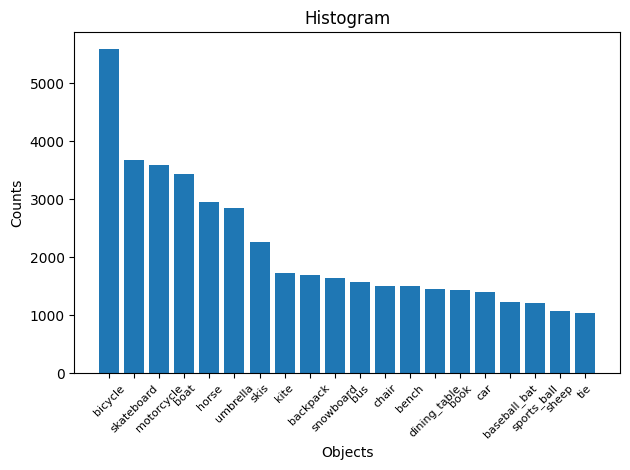

In [18]:
import matplotlib.pyplot as plt

data='train'
if data == 'train':
    sorted_obj_dict = train_sorted_obj_dict
    sorted_verb_dict = train_sorted_verb_dict
    sorted_hoi_dict = train_sorted_hoi_dict

x_values = [item[0] for item in sorted_obj_dict[1:21]]
y_values = [item[1] for item in sorted_obj_dict[1:21]]

plt.bar(x_values, y_values)

plt.xlabel('Objects')
plt.ylabel('Counts')
plt.title('Histogram')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()  # Ensures all elements are properly shown in the plot
plt.show()

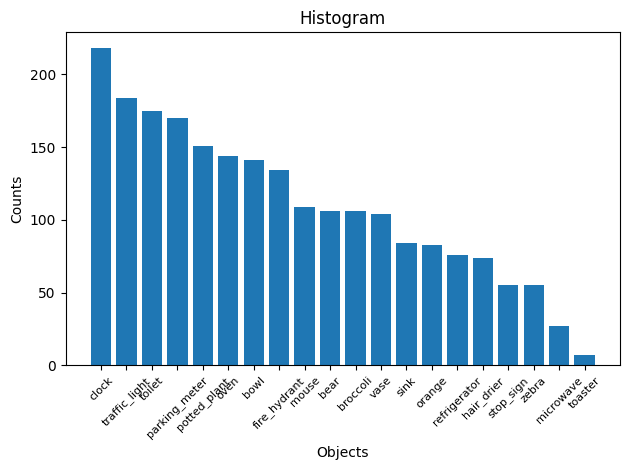

In [19]:
x_values = [item[0] for item in sorted_obj_dict[-20:]]
y_values = [item[1] for item in sorted_obj_dict[-20:]]

plt.bar(x_values, y_values)

plt.xlabel('Objects')
plt.ylabel('Counts')
plt.title('Histogram')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()  # Ensures all elements are properly shown in the plot
plt.show()

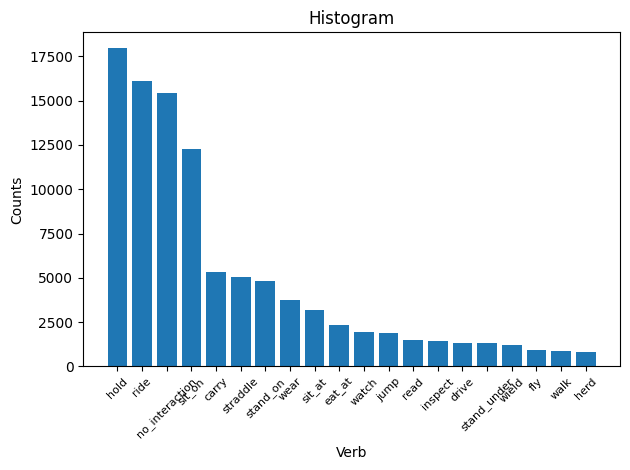

In [20]:
x_values = [item[0] for item in sorted_verb_dict[:20]]
y_values = [item[1] for item in sorted_verb_dict[:20]]

plt.bar(x_values, y_values)

plt.xlabel('Verb')
plt.ylabel('Counts')
plt.title('Histogram')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()  # Ensures all elements are properly shown in the plot
plt.show()

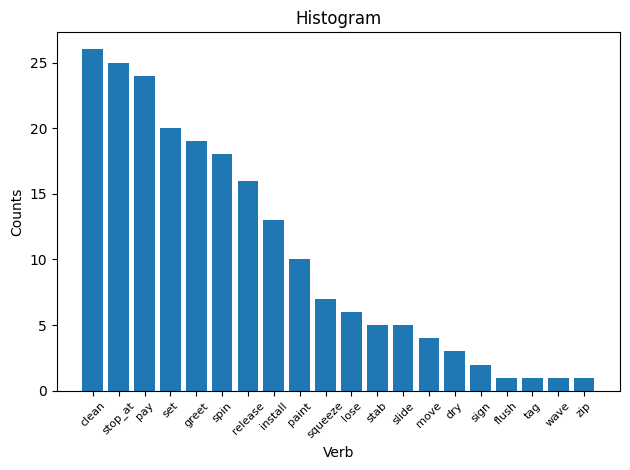

In [21]:
x_values = [item[0] for item in sorted_verb_dict[-20:]]
y_values = [item[1] for item in sorted_verb_dict[-20:]]

plt.bar(x_values, y_values)

plt.xlabel('Verb')
plt.ylabel('Counts')
plt.title('Histogram')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()  # Ensures all elements are properly shown in the plot
plt.show()

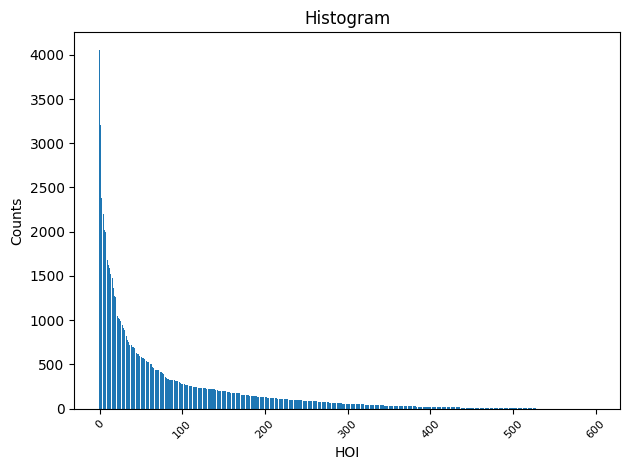

In [29]:
# x_values = [item[0] for item in sorted_hoi_dict[:100]]
x_values = [item for item in range(600)]
y_values = [item[1] for item in sorted_hoi_dict[:600]]

plt.bar(x_values, y_values)

plt.xlabel('HOI')
plt.ylabel('Counts')
plt.title('Histogram')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()  # Ensures all elements are properly shown in the plot
plt.show()

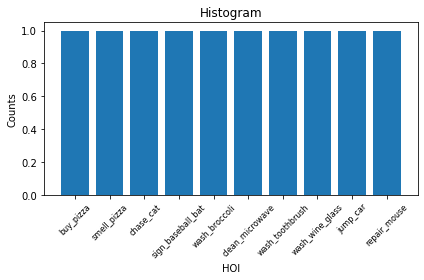

In [42]:
x_values = [item[0] for item in sorted_hoi_dict[-10:]]
y_values = [item[1] for item in sorted_hoi_dict[-10:]]

plt.bar(x_values, y_values)

plt.xlabel('HOI')
plt.ylabel('Counts')
plt.title('Histogram')

plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()  # Ensures all elements are properly shown in the plot
plt.show()

In [8]:
train_num_of_obj_img = {k: len(v) for k,v in train_num_of_obj_img.items()}
train_num_of_verb_img = {k: len(v) for k,v in train_num_of_verb_img.items()}
train_num_of_hoi_img = {k: len(v) for k,v in train_num_of_hoi_img.items()}

test_num_of_obj_img = {k: len(v) for k,v in test_num_of_obj_img.items()}
test_num_of_verb_img = {k: len(v) for k,v in test_num_of_verb_img.items()}
test_num_of_hoi_img = {k: len(v) for k,v in test_num_of_hoi_img.items()}

In [9]:
train_new_obj_img_dict = {}
for k,v in train_num_of_obj.items():
    train_new_obj_img_dict[obj_idx2class[k]] = v

train_new_verb_img_dict = {}
for k,v in train_num_of_verb.items():
    train_new_verb_img_dict[verb_idx2class[k]] = v

train_new_hoi_img_dict = {}
hoi_idx2class = {}
for k,v in train_num_of_hoi.items():
    verb_category_id, obj_category_id = train_hoi2verbobj[k]
    hoi_name = verb_idx2class[verb_category_id] + '_' + obj_idx2class[obj_category_id]
    train_new_hoi_img_dict[hoi_name] = v
    hoi_idx2class[k] = hoi_name

test_new_obj_img_dict = {}
for k,v in test_num_of_obj.items():
    test_new_obj_img_dict[obj_idx2class[k]] = v

test_new_verb_img_dict = {}
for k,v in test_num_of_verb.items():
    test_new_verb_img_dict[verb_idx2class[k]] = v

test_new_hoi_img_dict = {}
for k,v in test_num_of_hoi.items():
    verb_category_id, obj_category_id = test_hoi2verbobj[k]
    hoi_name = verb_idx2class[verb_category_id] + '_' + obj_idx2class[obj_category_id]
    test_new_hoi_img_dict[hoi_name] = v

In [10]:
train_sorted_obj_img_dict = sorted(train_new_obj_img_dict.items(), key = lambda item: item[1], reverse = True)
train_sorted_verb_img_dict = sorted(train_new_verb_img_dict.items(), key = lambda item: item[1], reverse = True)
train_sorted_hoi_img_dict = sorted(train_new_hoi_img_dict.items(), key = lambda item: item[1], reverse = True)

test_sorted_obj_img_dict = sorted(test_new_obj_img_dict.items(), key = lambda item: item[1], reverse = True)
test_sorted_verb_img_dict = sorted(test_new_verb_img_dict.items(), key = lambda item: item[1], reverse = True)
test_sorted_hoi_img_dict = sorted(test_new_hoi_img_dict.items(), key = lambda item: item[1], reverse = True)

In [11]:
print('HOI Image 기준')
print('------------------------')
print("Train")
print('------------------------')
print('non-rare-max:',np.max([train_num_of_hoi_img[r] for r in nonrare_class_idx]))
print('non-rare-min:',np.min([train_num_of_hoi_img[r] for r in nonrare_class_idx]))
print('non-rare-mean:',np.mean([train_num_of_hoi_img[r] for r in nonrare_class_idx]))
print('non-rare-median:',np.median([train_num_of_hoi_img[r] for r in nonrare_class_idx]))
print('')
print('rare-max:',np.max([train_num_of_hoi_img[r] for r in rare_class_idx]))
print('rare-min:',np.min([train_num_of_hoi_img[r] for r in rare_class_idx]))
print('rare-mean:',np.mean([train_num_of_hoi_img[r] for r in rare_class_idx]))
print('rare-median:',np.median([train_num_of_hoi_img[r] for r in rare_class_idx]))
print('------------------------')
print("Test")
print('------------------------')
print('non-rare-max:',np.max([test_num_of_hoi_img[r] for r in nonrare_class_idx]))
print('non-rare-min:',np.min([test_num_of_hoi_img[r] for r in nonrare_class_idx]))
print('non-rare-mean:',np.mean([test_num_of_hoi_img[r] for r in nonrare_class_idx]))
print('non-rare-median:',np.median([test_num_of_hoi_img[r] for r in nonrare_class_idx]))
print('')
print('rare-max:',np.max([test_num_of_hoi_img[r] for r in rare_class_idx]))
print('rare-min:',np.min([test_num_of_hoi_img[r] for r in rare_class_idx]))
print('rare-mean:',np.mean([test_num_of_hoi_img[r] for r in rare_class_idx]))
print('rare-median:',np.median([test_num_of_hoi_img[r] for r in rare_class_idx]))

HOI Image 기준
------------------------
Train
------------------------
non-rare-max: 1455
non-rare-min: 1
non-rare-mean: 149.3874458874459
non-rare-median: 62.5

rare-max: 9
rare-min: 1
rare-mean: 2.8043478260869565
rare-median: 2.0
------------------------
Test
------------------------
non-rare-max: 387
non-rare-min: 4
non-rare-mean: 41.768398268398265
non-rare-median: 19.0

rare-max: 9
rare-min: 2
rare-mean: 5.297101449275362
rare-median: 5.0


In [12]:
with open('paper_pretrained.json', 'r') as f:
    paper_pretrained_ap = json.load(f)
with open('reproduce_pretrained.json', 'r') as f:
    reproduce_pretrained_ap = json.load(f)

In [17]:
nonrare_trainnum_testnum_score_img = {nr : [train_num_of_hoi_img[nr], test_num_of_hoi_img[nr], paper_pretrained_ap[str(nr)]] for nr in nonrare_class_idx}
rare_trainnum_testnum_score_img = {r : [train_num_of_hoi_img[r], test_num_of_hoi_img[r],paper_pretrained_ap[str(r)]] for r in rare_class_idx}

sorted_nonrare_trainnum_testnum_score_img = sorted(nonrare_trainnum_testnum_score_img.items(), key=lambda x:x[1][-1], reverse=True)
sorted_rare_trainnum_testnum_score_img = sorted(rare_trainnum_testnum_score_img.items(), key=lambda x:x[1][-1])

In [24]:
idx

462

In [23]:
for idx in range(600): 
    if sorted_nonrare_trainnum_testnum_score_img[idx][0]==516:
        print(sorted_nonrare_trainnum_testnum_score_img[idx])

(516, [181, 50, 0.7128831164284999])


IndexError: list index out of range

In [17]:
sorted_rare_trainnum_testnum_score_img

[(63, [1, 4, 0.0]),
 (418, [1, 4, 0.0]),
 (395, [1, 2, 0.0]),
 (303, [1, 5, 0.0027002700270027003]),
 (504, [1, 3, 0.0031620553359683794]),
 (549, [2, 4, 0.003952569169960474]),
 (274, [3, 9, 0.004329004329004329]),
 (358, [1, 5, 0.007655502392344498]),
 (592, [1, 5, 0.008168249660786974]),
 (254, [3, 7, 0.009007396802672393]),
 (198, [5, 5, 0.009090909090909092]),
 (514, [1, 5, 0.01291866028708134]),
 (547, [2, 5, 0.01295731707317073]),
 (280, [1, 5, 0.012987012987012986]),
 (214, [8, 6, 0.014271151885830783]),
 (70, [1, 4, 0.01618445136636588]),
 (165, [5, 5, 0.016783216783216783]),
 (112, [2, 5, 0.023056653491436097]),
 (397, [1, 5, 0.0303030303030303]),
 (90, [1, 5, 0.031978664351169896]),
 (351, [1, 5, 0.032467532467532464]),
 (261, [2, 4, 0.03896103896103896]),
 (578, [5, 5, 0.050400181214134705]),
 (431, [4, 5, 0.05454545454545454]),
 (216, [4, 6, 0.057870370370370364]),
 (548, [1, 5, 0.057870370370370364]),
 (436, [3, 5, 0.0641711229946524]),
 (55, [4, 8, 0.06520955299788407]),

/home/unist/anaconda3/envs/handetector/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/unist/anaconda3/envs/handetector/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/unist/anaconda3/envs/handetector/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/unist/anaconda3/envs/handetector/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/unist/anaconda3/envs/handetector/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48143 (\N{H

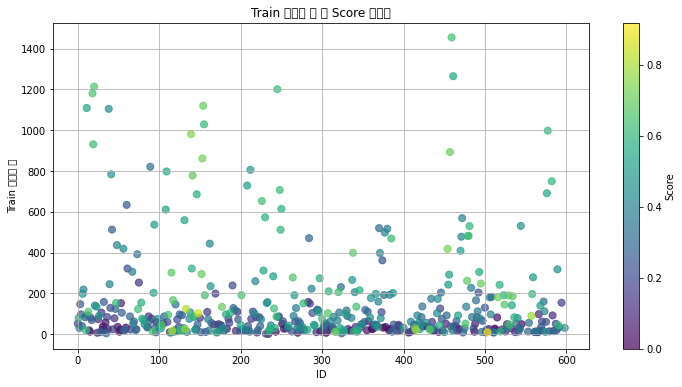

In [18]:
import matplotlib.pyplot as plt

# 주어진 데이터에서 id, train 이미지 수 및 score를 추출합니다.
ids = [item[0] for item in sorted_nonrare_trainnum_testnum_score_img]
train_image_count = [item[1][0] for item in sorted_nonrare_trainnum_testnum_score_img]
scores = [item[1][2] for item in sorted_nonrare_trainnum_testnum_score_img]

# 그래프를 그립니다.
plt.figure(figsize=(12, 6))
plt.scatter(ids, train_image_count, c=scores, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Score')
plt.title('Train 이미지 수 및 Score 시각화')
plt.xlabel('ID')
plt.ylabel('Train 이미지 수')
plt.grid(True)
plt.show()


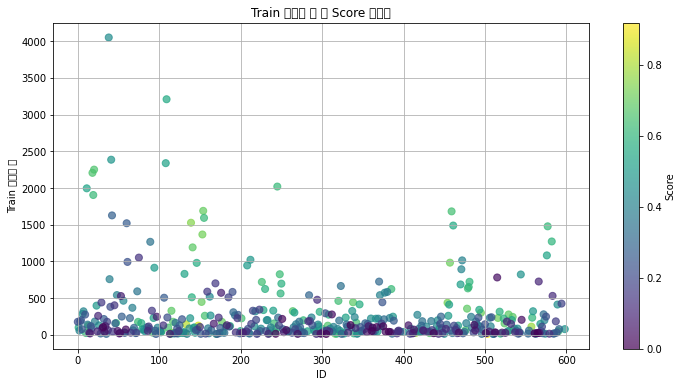

In [16]:
import matplotlib.pyplot as plt

# 주어진 데이터에서 id, train 이미지 수 및 score를 추출합니다.
ids = [item[0] for item in sorted_nonrare_trainnum_testnum_score]
train_image_count = [item[1][0] for item in sorted_nonrare_trainnum_testnum_score]
scores = [item[1][2] for item in sorted_nonrare_trainnum_testnum_score]

# 그래프를 그립니다.
plt.figure(figsize=(12, 6))
plt.scatter(ids, train_image_count, c=scores, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Score')
plt.title('Train 이미지 수 및 Score 시각화')
plt.xlabel('ID')
plt.ylabel('Train 이미지 수')
plt.grid(True)
plt.show()


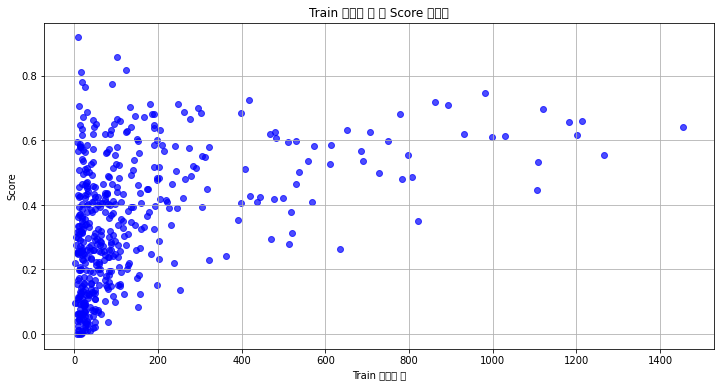

In [19]:
import matplotlib.pyplot as plt

# 주어진 데이터에서 train 이미지 수와 score를 추출합니다.
train_image_count = [item[1][0] for item in sorted_nonrare_trainnum_testnum_score_img]
scores = [item[1][2] for item in sorted_nonrare_trainnum_testnum_score_img]

# 그래프를 그립니다.
plt.figure(figsize=(12, 6))
plt.scatter(train_image_count, scores, c='blue', alpha=0.7)
plt.title('Train 이미지 수 및 Score 시각화')
plt.xlabel('Train 이미지 수')
plt.ylabel('Score')
plt.grid(True)
plt.show()


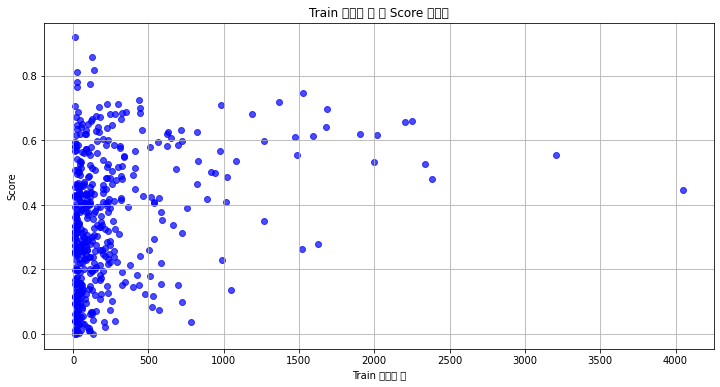

In [17]:
import matplotlib.pyplot as plt

# 주어진 데이터에서 train 이미지 수와 score를 추출합니다.
train_image_count = [item[1][0] for item in sorted_nonrare_trainnum_testnum_score]
scores = [item[1][2] for item in sorted_nonrare_trainnum_testnum_score]

# 그래프를 그립니다.
plt.figure(figsize=(12, 6))
plt.scatter(train_image_count, scores, c='blue', alpha=0.7)
plt.title('Train 이미지 수 및 Score 시각화')
plt.xlabel('Train 이미지 수')
plt.ylabel('Score')
plt.grid(True)
plt.show()


## New Data

In [83]:
import pickle
import json
import os

In [3]:
anno_file = '/mnt/HDD/hico_20160224_det/annotations/trainval_hico.json'

with open(anno_file, 'r') as f:
    annotations = json.load(f)
    
img_id = annotations[-1]['img_id'] + 1
len(annotations)

37633

In [84]:
anno_file = '/mnt/HDD/hico_20160224_det/annotations/trainval_hico_diffusion_replace.json'

with open(anno_file, 'r') as f:
    annotations = json.load(f)
    
img_id = annotations[-1]['img_id'] + 1
len(annotations)

41747

In [85]:
num_of_hoi[79]

52

In [86]:
new_anno = annotations[37633:]
hoi_set = list()
for anno in new_anno:
    for hoi in anno['hoi_annotation']:
        hoi_cat_id = hoi['hoi_category_id']
        hoi_set.append(hoi_cat_id)

In [87]:
len(new_anno)

4114

In [90]:
hico_text_label[list(hico_text_label)[77]]

'a photo of a person feeding a cat'

In [82]:
new_anno[1]

{'file_name': './hico_new_ver2/rare_new/feeding_cat/43.jpg',
 'img_id': 38154,
 'annotations': [{'bbox': [280, 0, 638, 476], 'category_id': 1},
  {'bbox': [157, 55, 360, 316], 'category_id': 17}],
 'hoi_annotation': [{'subject_id': 0,
   'object_id': 1,
   'category_id': 27,
   'hoi_category_id': 78},
  {'subject_id': 0, 'object_id': 1, 'category_id': 37, 'hoi_category_id': 79}],
 'original_img_path': 'HICO_train2015_00036108.jpg'}

In [75]:
hoi_set

[78,
 78,
 79,
 78,
 79,
 78,
 78,
 78,
 78,
 78,
 78,
 79,
 26,
 79,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 26,
 79,
 78,
 82,
 26,
 79,
 78,
 78,
 26,
 26,
 78,
 78,
 79,
 78,
 130,
 79,
 26,
 79,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 278,
 78,
 78,
 79,
 82,
 78,
 343,
 345,
 78,
 78,
 78,
 79,
 78,
 78,
 79,
 26,
 27,
 176,
 176,
 78,
 78,
 78,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 417,
 594,
 590,
 594,
 590,
 594,
 590,
 594,
 594,
 594,
 594,
 594,
 594,
 594,
 594,
 594,
 590,
 594,
 590,
 594,
 594,
 594,
 594,
 590,
 594,
 594,
 594,
 590,
 594,
 594,
 594,
 594,
 594,
 594,
 590,
 255,
 594,
 594,
 590,
 594,
 594,
 594,
 400,
 401,
 400,
 401,
 400,
 400,
 401,
 400,
 401,
 400,
 401,
 400,
 400,
 401,
 400,
 401,
 201,
 202,
 400,
 401,
 400,
 443,
 400,
 401,
 400,
 401,
 400,
 401,
 400,
 401,
 400,
 400,
 400,
 400,
 400,
 401,
 400,
 401,
 400,
 401,
 400,
 

In [64]:
set(hoi_set)

{5,
 9,
 12,
 13,
 15,
 21,
 23,
 26,
 27,
 28,
 30,
 35,
 38,
 39,
 45,
 49,
 51,
 56,
 59,
 63,
 67,
 70,
 71,
 75,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 91,
 95,
 99,
 100,
 101,
 104,
 105,
 106,
 108,
 116,
 117,
 118,
 119,
 120,
 121,
 126,
 127,
 129,
 130,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 140,
 142,
 145,
 146,
 147,
 148,
 150,
 154,
 156,
 158,
 159,
 173,
 175,
 176,
 178,
 179,
 180,
 181,
 182,
 184,
 185,
 187,
 189,
 190,
 191,
 193,
 196,
 199,
 200,
 201,
 202,
 203,
 206,
 207,
 209,
 213,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 238,
 239,
 240,
 253,
 255,
 256,
 258,
 259,
 260,
 261,
 262,
 274,
 275,
 276,
 277,
 278,
 280,
 281,
 283,
 285,
 287,
 290,
 292,
 293,
 298,
 299,
 304,
 305,
 306,
 307,
 308,
 309,
 312,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323,
 324,
 326,
 331,
 335,
 343,
 344,
 345,
 346,
 347,
 350,
 351,
 352,
 353,
 354,
 355,
 357,
 358,
 359,
 360,
 361,
 362,
 365,
 366,
 372,
 378,
 380,
 382,
 390,
 391,
 392

In [44]:
new_data_path = '/mnt/HDD/hico_20160224_det/images/train2015/rare_new'
root_path = '/mnt/HDD/hico_20160224_det/images/train2015/'


pkl_path = []
image_folder = []
for file in os.listdir(new_data_path):
    if file[-3:] == 'pkl':
        pkl_path.append(os.path.join(new_data_path, file))
    else:
        image_folder.append(os.path.join(new_data_path, file))

In [62]:
for folder in image_folder:
    folder_num = int(folder.split('/')[-1])
    with open(os.path.join(new_data_path, f'class_{folder_num}_annotation.pkl'), 'rb') as f:
        new_anno = pickle.load(f)
    img_file_list = os.listdir(folder)
    for img_file in img_file_list:
        key = img_file[:-4].split('_')[-1]
        new_file_name = os.path.join(folder, img_file).replace(root_path, '')
        new_anno[int(key)]['file_name'] = new_file_name
        new_anno[int(key)]['img_id'] = img_id
        img_id += 1
        # print(new_anno[int(key)])

        annotations.append(new_anno[int(key)])

In [63]:
len(annotations)

39752

In [64]:
with open('/mnt/HDD/hico_20160224_det/annotations/trainval_hico_newdata.json', 'w') as outfile:
    json.dump(annotations, outfile)

In [10]:
anno_file = '/home/unist/Downloads/rare/new_trainval_hico.json'

with open(anno_file, 'r') as f:
    annotations = json.load(f)
    
img_id = annotations[-1]['img_id'] + 1
len(annotations)

41747

In [15]:
annotations[0]

{'file_name': 'HICO_train2015_00000001.jpg',
 'img_id': 1,
 'annotations': [{'bbox': [207, 32, 426, 299], 'category_id': 1},
  {'bbox': [58, 97, 571, 404], 'category_id': 4}],
 'hoi_annotation': [{'subject_id': 0,
   'object_id': 1,
   'category_id': 73,
   'hoi_category_id': 153},
  {'subject_id': 0, 'object_id': 1, 'category_id': 77, 'hoi_category_id': 154},
  {'subject_id': 0, 'object_id': 1, 'category_id': 88, 'hoi_category_id': 155},
  {'subject_id': 0,
   'object_id': 1,
   'category_id': 99,
   'hoi_category_id': 156}]}

## New Data2

In [60]:
import pickle
import json
import os

In [61]:
anno_file = '/mnt/HDD/hico_20160224_det/annotations/trainval_hico.json'

with open(anno_file, 'r') as f:
    annotations = json.load(f)
    
img_id = annotations[-1]['img_id'] + 1
len(annotations)

37633

In [62]:
new_data_path = '/home/unist/Downloads/new_annotations.json'
with open(new_data_path, 'r') as f:
    new_anno = json.load(f)
    
len(new_anno)

1536

In [64]:
for new_ann in new_anno:
    new_ann['file_name'] = os.path.join('final_augmented', new_ann['file_name'])
    for new_hoi in new_ann['hoi_annotation']:
        new_hoi['category_id'] += 1

In [65]:
new_anno[0]

{'file_name': 'final_augmented/HICO_train2015_augmented00000001_stop sign to traffic light.jpg',
 'img_id': 38153,
 'annotations': [{'bbox': [309, 189, 459, 361], 'category_id': 1},
  {'bbox': [263, 186, 283, 222], 'category_id': 13}],
 'hoi_annotation': [{'hoi_category_id': 506,
   'subject_id': 0,
   'object_id': 1,
   'category_id': 58}]}

In [66]:
with open('/home/unist/Downloads/new_triplet.txt', 'r') as f:
    x = f.readlines()
    
hico_text_label = {}

for item in x:
    parts = item.strip().split(" : ")
    position = parts[0]
    description = parts[1]
    
    position_tuple = tuple(map(int, position[1:-1].split(', ')))
    
    hico_text_label[position_tuple] = description

In [67]:
idx2_verb_obj_pair = {i:k for i, (k,v) in enumerate(hico_text_label.items())}

final_augmented/HICO_train2015_augmented00001112_hair drier to handbag.jpg
37


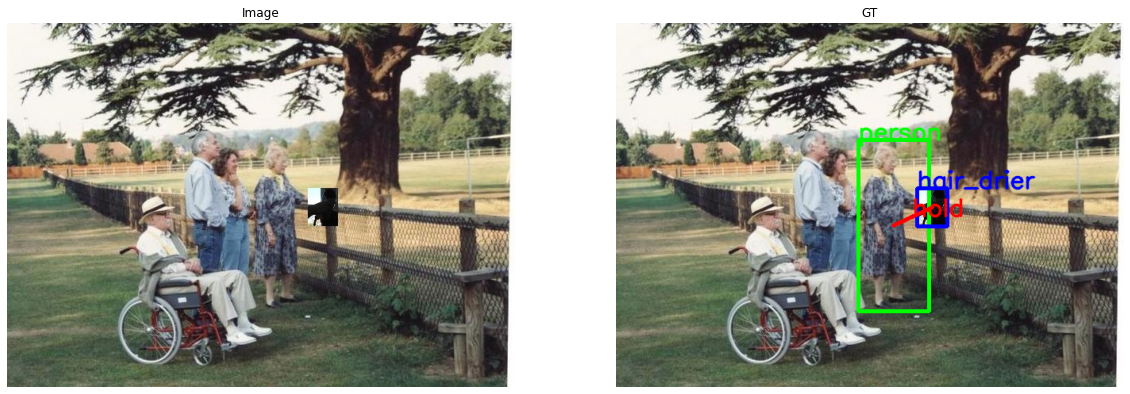

In [68]:
import cv2

# root_path = '/mnt/HDD/hico_20160224_det/images/train2015'
root_path = '/home/unist/Downloads'
idx = 1111
img_path = new_anno[idx]['file_name']
img = cv2.imread(os.path.join(root_path,img_path))
ori_img = img.copy()
print(img_path)

results = []
for k, anno in enumerate(new_anno[idx]['hoi_annotation']):
    sub_id = anno['subject_id']
    obj_id = anno['object_id']
    sub_info = new_anno[idx]['annotations'][sub_id]
    obj_info = new_anno[idx]['annotations'][obj_id]
    
    sub_category_id = sub_info['category_id']
    obj_category_id = obj_info['category_id']
    
    sub_category = obj_idx2class[sub_category_id]
    obj_category = obj_idx2class[obj_category_id]
    
    sub_bbox = sub_info['bbox']
    obj_bbox = obj_info['bbox']
    
    sub_center = ((sub_bbox[0] + sub_bbox[2])//2, (sub_bbox[1] + sub_bbox[3])//2)
    obj_center = ((obj_bbox[0] + obj_bbox[2])//2, (obj_bbox[1] + obj_bbox[3])//2)
    
    print(anno['category_id'])
    verb_category = verb_idx2class[anno['category_id']]
    
    cv2.rectangle(img, sub_bbox[:2], sub_bbox[2:], (0,255,0), 3)
    cv2.rectangle(img, obj_bbox[:2], obj_bbox[2:], (255,0,0), 3)
    cv2.line(img, sub_center, obj_center, (0,0,255), thickness=3)
    
    verb_loc = [(sub_center[0] + obj_center[0])//2, (sub_center[1] + obj_center[1])//2]
    verb_loc[1] += k*20
    cv2.putText(img, sub_category, sub_bbox[:2], cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
    cv2.putText(img, obj_category, obj_bbox[:2], cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    cv2.putText(img, verb_category, verb_loc, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)
    
    result_dict = {}
    result_dict['verb'] = verb_category
    result_dict['object'] = obj_category
    result_dict['sub_bbox'] = sub_bbox
    result_dict['obj_bbox'] = obj_bbox
    
    results.append(result_dict)
    
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(ori_img[...,::-1])
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(img[...,::-1])
axes[1].set_title('GT')
axes[1].axis('off')

plt.show()

In [69]:
len(new_anno)

1536

In [70]:
new_anno = annotations + new_anno

In [71]:
len(new_anno)

39169

In [72]:
with open('/mnt/HDD/hico_20160224_det/annotations/trainval_hico_newdata_cutmix.json', 'w') as outfile:
    json.dump(annotations, outfile)

### GLIGEN

In [28]:
anno_file = '/mnt/HDD/hico_20160224_det/annotations/trainval_hico.json'
with open(anno_file, 'r') as f:
    annotations = json.load(f)

new_data_path = '/mnt/HDD/hico_20160224_det/annotations/new_annotations.json'
with open(new_data_path, 'r') as f:
    new_anno = json.load(f)

In [29]:
gligen_annotation = annotations + new_anno
with open('/mnt/HDD/hico_20160224_det/annotations/gligen_cook_carrot.json', 'w') as f:
    json.dump(gligen_annotation, f)

## Non rare 하나 클래스 대체

In [47]:
anno_file = '/mnt/HDD/hico_20160224_det/annotations/trainval_hico.json'
with open(anno_file, 'r') as f:
    annotations = json.load(f)

new_data_path = '/mnt/HDD/hico_20160224_det/annotations/new_annotations_carrying_surfboard.json'
with open(new_data_path, 'r') as f:
    new_anno = json.load(f)

In [48]:
non_rare_hoi_idx = 516
remove_nonrare_one_class = []
nonrare_one_class_idx = []
for idx,anno in enumerate(annotations):
    if non_rare_hoi_idx in [an['hoi_category_id']-1 for an in anno['hoi_annotation']]:
        nonrare_one_class_idx.append(idx)
    else:
        remove_nonrare_one_class.append(anno)  
    if 57 in [an['category_id'] for an in anno['annotations']]:
        print(idx)

12
142
389
482
675
1023
1105
1467
1546
1548
1642
1881
1900
1912
1997
2408
2982
3231
3535
3736
3881
3886
3913
3930
4451
4637
4923
5340
5679
5698
5764
5862
6025
6124
6256
6404
6456
6544
6658
6664
6974
6976
7103
7122
7159
7275
7359
7392
7436
7577
7966
7976
7998
8560
8576
9088
9209
9522
9571
9734
10091
10186
10249
10251
10533
10860
11149
11268
11566
11836
12025
12404
13198
13328
13413
13672
14007
14092
14135
14147
14316
14347
14591
14615
14813
14859
15033
15301
15333
15435
15455
15469
15831
16208
16658
17054
17348
17388
17449
17697
18351
18370
18394
18452
18455
18962
19082
19357
19618
19719
19778
20008
20025
20034
20171
20285
20393
20781
20870
20944
21079
21545
21664
22744
22826
22963
23056
23067
23276
23331
23629
23952
24047
24179
24925
25061
25318
25344
25384
26049
26555
26664
27054
27151
27305
27416
27491
27620
27710
27795
28040
28065
28238
29022
29537
29755
29810
29815
29906
29933
30375
30454
30813
31294
31324
31471
31478
32192
32292
32325
32584
32929
33393
33483
33501
33522
33609
3368

In [61]:
len(remove_nonrare_one_class + new_anno)

37633

In [62]:
gligen_annotation = remove_nonrare_one_class + new_anno
with open('/mnt/HDD/hico_20160224_det/annotations/gligen_carry_surfboard.json', 'w') as f:
    json.dump(gligen_annotation, f)

In [34]:
nonrare_one_class_idx

[424,
 1052,
 1064,
 1260,
 1393,
 1451,
 1461,
 1787,
 2087,
 2357,
 2585,
 2685,
 2714,
 2732,
 3141,
 3232,
 3408,
 3568,
 3709,
 3879,
 4561,
 4705,
 4913,
 5022,
 5024,
 5197,
 5314,
 5412,
 5965,
 6018,
 6065,
 6204,
 6229,
 6263,
 6872,
 7042,
 7607,
 7841,
 8196,
 8618,
 8628,
 9029,
 9037,
 9054,
 9871,
 9985,
 10089,
 10351,
 10696,
 10914,
 11036,
 11071,
 11283,
 11340,
 11531,
 12008,
 12012,
 12030,
 12050,
 12150,
 12267,
 12787,
 13046,
 13266,
 13386,
 13423,
 13436,
 13500,
 13595,
 13754,
 13781,
 13844,
 14028,
 14223,
 14709,
 15057,
 15659,
 16156,
 16159,
 16268,
 16318,
 16338,
 16681,
 17119,
 18030,
 18184,
 18209,
 18225,
 18662,
 18710,
 18964,
 19006,
 19060,
 19141,
 19945,
 20369,
 20942,
 21084,
 21110,
 21186,
 21247,
 21271,
 21386,
 21775,
 21968,
 21981,
 22507,
 22670,
 22763,
 22835,
 22913,
 23015,
 23024,
 23037,
 23146,
 23246,
 23341,
 23408,
 23425,
 23789,
 23910,
 24076,
 24080,
 24381,
 24411,
 24465,
 24958,
 25131,
 25159,
 25162,
 25187,